## Dentate gyrus (scRNA-seq) | Training with an RNA-dynamics kNN-graph

The studied dataset for this tutorial is dentate gyrus (10X Genomics) {cite}`Hochgerner2018`, and it is loaded directly from `scvelo.datasets`.

In [231]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [233]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [234]:
import pandas as pd
import numpy as np
import os
import seaborn
import itertools
import glob

import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [235]:
# these are motifs used during training (pre-weights)
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [236]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [237]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [238]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
# mb.models.Mubind
import torch
import torch
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle


# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [239]:
# device = 'cpu'

In [240]:
import scanpy as sc

In [241]:
print('here...')

here...


In [242]:
ad_path = '../../../data/dentategyrus/dentategyrus.h5ad'
os.path.exists(ad_path)

True

In [243]:
print('here...')

here...


In [244]:
# pybiomart is requred
annot = sc.queries.biomart_annotations(
    "mmusculus",
    ["ensembl_gene_id", "start_position", "end_position", "chromosome_name", "external_gene_name"],
).set_index("external_gene_name")


In [245]:
tss_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'mm10', 'genome', 'TSS.in')
tss = pd.read_csv(tss_path, sep='\t', header=None)
tss.columns = ['chrom', 'pos', 'strand', 'symbol']
tss = tss.set_index('symbol')
tss = tss[~tss.index.duplicated(keep='first')]

In [246]:
# annot = annot[~annot.index.duplicated(keep='first')]

In [247]:
# load the pancreas multiome dataset
rna = sc.read_h5ad(ad_path)
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')

In [248]:
rna.var[tss.columns] = tss

In [249]:
rna = rna[:,~pd.isnull(rna.var['pos'])].copy()


In [250]:
rna.shape

(2930, 13197)

In [251]:
rna.var['tss_start'] = rna.var['pos'].astype(int)
rna = rna[:,~pd.isnull(rna.var['tss_start'])]
bp = 250
tss_start = rna.var['tss_start'].astype(int)
rna.var['tss_start'] = np.where(rna.var['strand'] == '+', tss_start - bp, tss_start)
rna.var['tss_end'] = np.where(rna.var['strand'] == '+', tss_start, tss_start + bp)

rna.var['chromosome_name'] = rna.var['chrom']
rna.var['k'] = rna.var['chromosome_name'].astype(str) + ':' + rna.var['tss_start'].astype(str) + '-' + rna.var['tss_end'].astype(str)

In [252]:
rna.var

,gene_count_corr,velocity_gamma,velocity_qreg_ratio,velocity_r2,velocity_genes,chrom,pos,strand,tss_start,tss_end,chromosome_name,k
index,,,,,,,,,,,,
Lypla1,0.0100,0.000000,0.000000,0.000000,False,chr1,4807893.0,+,4807643,4807893,chr1,chr1:4807643-4807893
Tcea1,-0.0791,0.278561,0.278561,-0.116783,False,chr1,4857694.0,+,4857444,4857694,chr1,chr1:4857444-4857694
Atp6v1h,0.0727,0.368721,0.368721,-0.505921,False,chr1,5083086.0,+,5082836,5083086,chr1,chr1:5082836-5083086
Rb1cc1,-0.0157,0.220445,0.220445,-0.205280,False,chr1,6214662.0,+,6214412,6214662,chr1,chr1:6214412-6214662
St18,-0.0037,0.052986,0.052986,-0.042492,False,chr1,6730051.0,+,6729801,6730051,chr1,chr1:6729801-6730051
...,...,...,...,...,...,...,...,...,...,...,...,...
Kdm5d,-0.0262,0.264588,0.308064,0.055893,True,chrY,897788.0,+,897538,897788,chrY,chrY:897538-897788
Eif2s3y,-0.0675,0.055193,0.055193,-0.131292,False,chrY,1010612.0,+,1010362,1010612,chrY,chrY:1010362-1010612
Erdr1,-0.0171,1.310422,1.310422,-0.146096,False,chrY,90785442.0,+,90785192,90785442,chrY,chrY:90785192-90785442


In [253]:
ad = rna

In [254]:
ad.var_names

Index(['Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'St18', 'Pcmtd1', 'Rrs1',
       'Adhfe1', '3110035E14Rik', 'Sgk3',
       ...
       'Tlr7', 'Prps2', 'Frmpd4', 'Msl3', 'Hccs', 'Kdm5d', 'Eif2s3y', 'Erdr1',
       'Uty', 'Ddx3y'],
      dtype='object', name='index', length=13197)

In [255]:
ad

AnnData object with n_obs × n_vars = 2930 × 13197
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'n_counts', 'velocity_self_transition'
    var: 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k'
    uns: 'clusters_colors', 'clusters_enlarged_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [256]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


In [257]:
rna.obs

,clusters,age(days),clusters_enlarged,n_counts,velocity_self_transition
index,,,,,
AAACATACCCATGA,Granule immature,35,Granule-immature,2460.500000,0.051353
AAACATACCGTAGT,Radial Glia-like,12,Radial Glia-like,2460.499756,0.220968
AAACATACGAGAGC,Granule mature,35,Granule-mature,2460.499756,0.069691
AAACATACTGAGGG,Granule immature,12,Granule-immature,2460.500000,0.080728
AAACATTGGCATCA,Granule immature,35,Granule-immature,2460.500000,0.119560
...,...,...,...,...,...
TTTCTACTTCCCGT,Granule immature,35,Granule-immature,2460.500000,0.034482
TTTGACTGCCTGTC,Neuroblast,12,Neuroblast 2,2460.499756,0.131426
TTTGACTGTCTGGA,Granule mature,35,Granule-mature,2460.499756,0.100035


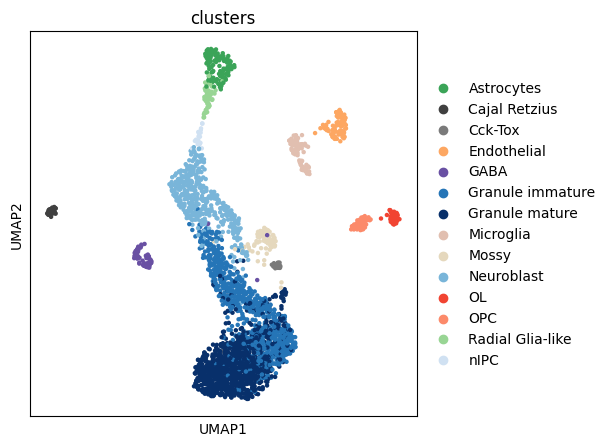

In [258]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='clusters')

#ATAC
# sc.pl.umap(atac, color='celltype')

In [259]:
rna

AnnData object with n_obs × n_vars = 2930 × 13197
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'n_counts', 'velocity_self_transition'
    var: 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k'
    uns: 'clusters_colors', 'clusters_enlarged_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [260]:
# scv.pl.velocity_embedding_stream(rna, color='celltype')

(array([  62.,   63.,   64.,   50.,   45.,   61.,   62.,   49.,   77.,
          82.,   85.,   84.,   73.,   98.,   94.,  126.,  124.,  134.,
         142.,  126.,  150.,  184.,  218.,  219.,  299.,  330.,  395.,
         437.,  482.,  611.,  719.,  937., 1106., 1581., 3828.]),
 array([0.00068259, 0.01494881, 0.02921502, 0.04348123, 0.05774744,
        0.07201365, 0.08627986, 0.10054608, 0.11481229, 0.1290785 ,
        0.14334471, 0.15761092, 0.17187713, 0.18614334, 0.20040956,
        0.21467577, 0.22894198, 0.24320819, 0.2574744 , 0.27174061,
        0.28600683, 0.30027304, 0.31453925, 0.32880546, 0.34307167,
        0.35733788, 0.3716041 , 0.38587031, 0.40013652, 0.41440273,
        0.42866894, 0.44293515, 0.45720137, 0.47146758, 0.48573379,
        0.5       ]),
 <BarContainer object of 35 artists>)

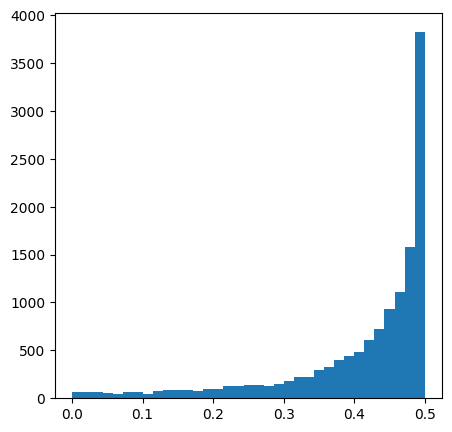

In [261]:
acc = (rna.X != 0).sum(axis=0) / rna.shape[0]
acc_score = abs(.5 - acc)
rna.var['acc_score'] = acc_score.A.T
rna.var['acc_score_rank'] = rna.var['acc_score'].rank(ascending=False)
plt.hist(rna.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [262]:
# n_sample_cells = 750
# n_sample_peaks = 1500

In [263]:
n_cell_types = len(set(rna.obs['clusters']))

In [264]:
n_cell_types

14

In [265]:
rna.shape

(2930, 13197)

In [266]:
rna.obs['clusters'].value_counts()

clusters
Granule mature      1070
Granule immature     785
Neuroblast           417
Astrocytes           120
Endothelial           87
Microglia             81
Mossy                 75
GABA                  61
OPC                   53
Radial Glia-like      51
OL                    50
Cajal Retzius         34
Cck-Tox               27
nIPC                  19
Name: count, dtype: int64

In [267]:
rna.shape

(2930, 13197)

In [268]:
 # int(n_sample_cells * 1.5)
n_select = 50000
n_sample_cells = n_select
n_sample_peaks = rna.shape[1]
# n_select =  int(n_sample_cells / n_cell_types) # bug if > 20
obs_sample = rna.obs.groupby('clusters').sample(n_select, random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(rna.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = rna[rna.obs_names.isin(obs_sample),rna.var_names.isin(var_sample)].copy()
rna.shape, ad.shape

((2930, 13197), (2930, 13197))

In [269]:
n_sample_peaks

13197

In [270]:
ad.obs['clusters'].value_counts()

clusters
Granule mature      1070
Granule immature     785
Neuroblast           417
Astrocytes           120
Endothelial           87
Microglia             81
Mossy                 75
GABA                  61
OPC                   53
Radial Glia-like      51
OL                    50
Cajal Retzius         34
Cck-Tox               27
nIPC                  19
Name: count, dtype: int64

In [271]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [272]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(2930, 2930)

In [273]:
# pip install scvelo

In [274]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

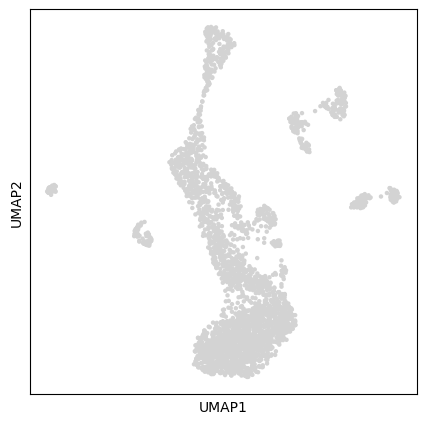

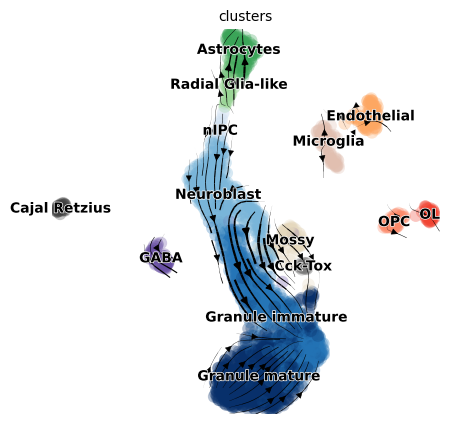

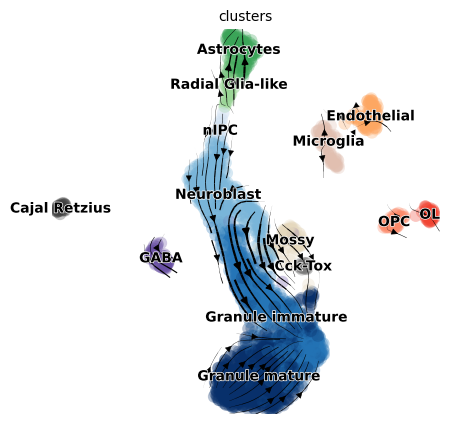

In [275]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [276]:
# ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
# ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
# ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

# print('features by chromosome')
# extend = 50
# ad.var['chr'].value_counts()

In [277]:
# ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
# ad.var['summit.start'] = ad.var['summit'] - extend
# ad.var['summit.end'] = ad.var['summit'] + extend
# ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)
ad.var['chr'] = ad.var['chrom'].astype(str)
ad.var['summit.start'] = ad.var['tss_start'].astype(str)
ad.var['summit.end'] = ad.var['tss_end'].astype(str)
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [278]:
# remove chromosome duplicates
dups = (ad.var['k.summit'].value_counts() > 1)
dups = dups[dups].index
ad = ad[:,~ad.var['k.summit'].isin(dups)]

In [279]:
n_seqs = ad.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/miniconda3/envs/mubind/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpkkt8i4gm
genome mm10 True
annotations/mm10/genome/mm10.fa
True annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/miniconda3/envs/mubind/bin/bedtools', 'getfasta', '-fi', 'annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpkkt8i4gm', '-fo', '/tmp/tmpbvu7zyt4']
/home/ilibarra/miniconda3/envs/mubind/bin/bedtools getfasta -fi annotations/mm10/genome/mm10.fa -bed /tmp/tmpkkt8i4gm -fo /tmp/tmpbvu7zyt4


13187

In [280]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [281]:
ad.shape, counts.shape

((2930, 13187), (13187, 2930))

In [282]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [283]:
counts.shape, next_data.shape

((13187, 2930), (13187, 2930))

In [284]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [285]:
next_data.shape, ad.shape

((13187, 2931), (2930, 13187))

In [286]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(13187, 2931)

In [287]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(13184, 2931)

In [288]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [289]:
n_cells = ad.shape[0] # next_data.shape[1]
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [290]:
next_data.shape

(13184, 2931)

In [291]:
n_cells

2930

In [292]:
ad.shape

(2930, 13187)

In [293]:
# next_data.index

In [294]:
ad.shape

(2930, 13187)

In [295]:
next_data = next_data[~next_data.index.duplicated(keep='first')]

In [296]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel.shape

(2930, 2931)

In [297]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,2921,2922,2923,2924,2925,2926,2927,2928,2929,var
seq,,,,,,,,,,,,,,,,,,,,,
ACGCAGAGCCCGGAGCGCCGGTATTTATTGCAAAGGGACACGTCACTCCACCGGAACCTAGTAACCCTCCACCACCTTGGTGAAGGAAGAAAAATAGTTCCTCAGAGAGTTAAAAATAGATCCTGACTTCCAAGTTTCTAGATTTTTCTTGACGTCGTGTGGGCCTCTTGGACCTTGCTAATACAGAGAAATGTTTAGCTTGTACCAGCTAAATAGGTACAAATAGGTTTAAAATTTCTGGTCACAAGGA,192.896332,146.569702,176.720993,74.879700,212.214920,34.730770,103.064430,63.729908,27.008781,207.418335,...,330.720581,143.385773,152.479034,17.642859,101.004532,94.754105,160.864792,93.063194,78.259262,6649.693359
GCGGCCACCCTCCCTTTTCCGTCTGCCCCCTAGCGGGCCCCGCCTCCTCTTCCGAACGGCCCCGCCCTCCCTCTGCTTCAGTCAGCTGCTAGTCTGTTCTTGCCTTGTAGGTCAGATACCTCTTAAAGAGCTGCCAGATTCCCATTCCCTGCTGAGCCTCCCCTCCCCCATCCCTGCCCCGCCTCTCCCTTCCTTCTTCACTCTTAGCTTTCTGTTCTTACCAGTTCCTCTTCTGTGCCCTTTTCCACAG,0.857317,43.659061,0.000000,0.584998,0.000000,0.538462,0.000000,0.657009,44.564491,0.000000,...,1.531114,0.000000,0.947075,4.071429,1.485361,1.553346,0.000000,295.078430,0.000000,1339.492188
ATCATCCTCATCGGTACCCTCTGTGCCCATCTGGGACCCAGATGCCTCTGCAGTACGGCTAGATCCAACTACGCCCGCCCCGGGCCACAGAAACAGCGCGCTTGTTGCCAGGCACCGCTCTTGCAGAAGCTCAGAGCCCCTTGCGTCGCCTCACACTCACACAGGCTCCTCCCCGCCCGCGCCCTGCGGGTTTGGGCAACACGCCCACAGGAAGAGGCGGGGCGGCGCGGCCCGCTGCGCTGATTGGCCA,32.578049,8.316011,36.250458,31.589874,32.386211,15.615385,43.052227,29.565422,13.504391,50.558216,...,26.028936,54.486595,33.147614,8.142858,35.648659,20.193497,34.122833,4.539668,51.694191,370.427185
ACCCCTCCATTTAATTTACACCCCTAATTCACACTTCCTGATTTATTTAAAGCAAAATGAAATTCTAGAGAAGCTTTAGGGGGGAAAAGAGAGAGAAAGAAAAAAAACAATTGGGAGTGAAAAGGCATAAAGAGAAGATGGAGCCCTTAAAGAAGGGAGTATCCCAAAGGAGGTGGGGACAAGGGGAGGAGAAGGGGAGGAGGAGAGGAGGAGGGAAACGAGCCTGTCTCTTTAAGGGGGTTGGCTGTCA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,360.813110
AGAGGGCACTGTGGAGACCCCCTATTTATGAGTCAGGCTTGGCCTCCACCCAAAGCCCAAGGACTGCCCACTGAAGGCTCGTGATGTTGGTGTGAGGGAGGGTGGCTGTCCCAGCTGCAGCCTCATCTGCTAATTATGTAAGAGGTTCCAGCTGAGCCCCACACCTCCTAGAAGAAGAAACCTCTGCCTGCCCCCATCCCCAGCTCCAGAGGCAGAACTGGCTCAGACCTTGCCCACTCCTGCCGGCAAA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217.319138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCCCGGGCCCGCGCCGCGCGCCCCCGCCTGCGCCGCCGCGCCCGCGCCACGCCGCGCGCCCCCGCGCCAGCTCTCTCTCGCGCTCTCTCTCTCCAGCTCGCTCTGTCTCTCTGTCTCTCTCCCCTTTCTTTCTCTGTCTCTCTCCTCTCTCTGTCTGTCTCTCTCTCTCTGTGTCTCTCCCCCCTCTCTTTCTCTGTCTCTCTCTCTCCTCTCTCTGTGTCTCTCTGTCTGTCTGTCTCTCTCTCTGTGT,0.857317,0.000000,0.000000,0.000000,0.000000,0.000000,1.304613,0.000000,0.000000,0.000000,...,0.000000,7.169289,0.000000,0.000000,0.742680,0.000000,0.000000,0.000000,0.000000,0.214795
TCCAGGGCTTTGACTTGCCGCACTCGGTGACCGGCCTGCAGTCCTCGGCGGAGCCGCGCGGGGGCGCTGCGGGGAGGCCTCGGCTTTCCTGCCGTGGCGGGGCACGGCCAGGCGGGGGCGCTGCGGGCGGCGGGCGAGGGCTAGGCCGGCCTCTCCTGCGGGGCCGGCTGGGGCGGGGCGCGGCGCCGCACCGCGCTTCCGCAAGTGTGGAGCTGCGGGATGGCTACGCTGCTACTGCAGCTGCTGGGGC,0.000000,0.000000,0.000000,0.000000,0.852269,0.000000,0.000000,0.000000,1.350439,0.000000,...,0.000000,0.000000,0.000000,2.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.214610
TCCCGCTCTAAAAGCGCAAGCCCACGTGGGGGCGGGGCGGCTCACCCGGAAGCGGCTCCCGTACCGCCCGCCCCTCCGGGAATGCAGCTTACGCTCCCTTCGGGGCAGTCTCCGGATCACTGGTCAGCTCGCGCGGCCAGATCCACGCTGAGCGGGGCTGGAATCTTGGCCAATCCAGAGTTGCCCGAGAGCCCGCCCGTCTCCCCGCCCCCCAGCTCGGGTCTCACTTGAGGTGGGAAGGCCCGAGGGG,0.857317,0.000000,1.510436,0.584998,0.000000,0.269231,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.433858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214427


In [298]:
ad.shape

(2930, 13187)

In [299]:
len(top_var), next_data.shape

(2930, (13183, 2931))

In [300]:
ad.shape

(2930, 13187)

In [301]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']
next_data_sel.shape

(2930, 2930)

In [302]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(2930, 2930)

In [303]:
ad.shape, df.shape

((2930, 13187), (2930, 2930))

In [304]:
zero_counts.shape

(2930,)

In [305]:
zero_counts.shape, ad.shape

((2930,), (2930, 13187))

In [306]:
ad.shape, zero_counts.shape

((2930, 13187), (2930,))

In [307]:
ad = ad[~zero_counts,:].copy()


In [308]:
ad.shape

(2930, 13187)

In [309]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(8584900, 3)
2930
batch
0      2930
137    2930
127    2930
128    2930
129    2930
       ... 
69     2930
70     2930
71     2930
72     2930
199    2930
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
ACGCAGAGCCCGGAGCGCCGGTATTTATTGCAAAGGGACACGTCACTCCACCGGAACCTAGTAACCCTCCACCACCTTGGTGAAGGAAGAAAAATAGTTCCTCAGAGAGTTAAAAATAGATCCTGACTTCCAAGTTTCTAGATTTTTCTTGACGTCGTGTGGGCCTCTTGGACCTTGCTAATACAGAGAAATGTTTAGCTTGTACCAGCTAAATAGGTACAAATAGGTTTAAAATTTCTGGTCACAAGGA,1.0,192.896332,0
GCGGCCACCCTCCCTTTTCCGTCTGCCCCCTAGCGGGCCCCGCCTCCTCTTCCGAACGGCCCCGCCCTCCCTCTGCTTCAGTCAGCTGCTAGTCTGTTCTTGCCTTGTAGGTCAGATACCTCTTAAAGAGCTGCCAGATTCCCATTCCCTGCTGAGCCTCCCCTCCCCCATCCCTGCCCCGCCTCTCCCTTCCTTCTTCACTCTTAGCTTTCTGTTCTTACCAGTTCCTCTTCTGTGCCCTTTTCCACAG,1.0,0.857317,0
ATCATCCTCATCGGTACCCTCTGTGCCCATCTGGGACCCAGATGCCTCTGCAGTACGGCTAGATCCAACTACGCCCGCCCCGGGCCACAGAAACAGCGCGCTTGTTGCCAGGCACCGCTCTTGCAGAAGCTCAGAGCCCCTTGCGTCGCCTCACACTCACACAGGCTCCTCCCCGCCCGCGCCCTGCGGGTTTGGGCAACACGCCCACAGGAAGAGGCGGGGCGGCGCGGCCCGCTGCGCTGATTGGCCA,1.0,32.578049,0
ACCCCTCCATTTAATTTACACCCCTAATTCACACTTCCTGATTTATTTAAAGCAAAATGAAATTCTAGAGAAGCTTTAGGGGGGAAAAGAGAGAGAAAGAAAAAAAACAATTGGGAGTGAAAAGGCATAAAGAGAAGATGGAGCCCTTAAAGAAGGGAGTATCCCAAAGGAGGTGGGGACAAGGGGAGGAGAAGGGGAGGAGGAGAGGAGGAGGGAAACGAGCCTGTCTCTTTAAGGGGGTTGGCTGTCA,1.0,0.000000,0
AGAGGGCACTGTGGAGACCCCCTATTTATGAGTCAGGCTTGGCCTCCACCCAAAGCCCAAGGACTGCCCACTGAAGGCTCGTGATGTTGGTGTGAGGGAGGGTGGCTGTCCCAGCTGCAGCCTCATCTGCTAATTATGTAAGAGGTTCCAGCTGAGCCCCACACCTCCTAGAAGAAGAAACCTCTGCCTGCCCCCATCCCCAGCTCCAGAGGCAGAACTGGCTCAGACCTTGCCCACTCCTGCCGGCAAA,1.0,0.000000,0


### Simple motif enrichment

In [310]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [311]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [312]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [313]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [314]:
reduced_groups = pwms

In [315]:
df

,0,1,2,3,4,5,6,7,8,9,...,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929
seq,,,,,,,,,,,,,,,,,,,,,
ACGCAGAGCCCGGAGCGCCGGTATTTATTGCAAAGGGACACGTCACTCCACCGGAACCTAGTAACCCTCCACCACCTTGGTGAAGGAAGAAAAATAGTTCCTCAGAGAGTTAAAAATAGATCCTGACTTCCAAGTTTCTAGATTTTTCTTGACGTCGTGTGGGCCTCTTGGACCTTGCTAATACAGAGAAATGTTTAGCTTGTACCAGCTAAATAGGTACAAATAGGTTTAAAATTTCTGGTCACAAGGA,192.896332,146.569702,176.720993,74.879700,212.214920,34.730770,103.064430,63.729908,27.008781,207.418335,...,37.665909,330.720581,143.385773,152.479034,17.642859,101.004532,94.754105,160.864792,93.063194,78.259262
GCGGCCACCCTCCCTTTTCCGTCTGCCCCCTAGCGGGCCCCGCCTCCTCTTCCGAACGGCCCCGCCCTCCCTCTGCTTCAGTCAGCTGCTAGTCTGTTCTTGCCTTGTAGGTCAGATACCTCTTAAAGAGCTGCCAGATTCCCATTCCCTGCTGAGCCTCCCCTCCCCCATCCCTGCCCCGCCTCTCCCTTCCTTCTTCACTCTTAGCTTTCTGTTCTTACCAGTTCCTCTTCTGTGCCCTTTTCCACAG,0.857317,43.659061,0.000000,0.584998,0.000000,0.538462,0.000000,0.657009,44.564491,0.000000,...,0.000000,1.531114,0.000000,0.947075,4.071429,1.485361,1.553346,0.000000,295.078430,0.000000
ATCATCCTCATCGGTACCCTCTGTGCCCATCTGGGACCCAGATGCCTCTGCAGTACGGCTAGATCCAACTACGCCCGCCCCGGGCCACAGAAACAGCGCGCTTGTTGCCAGGCACCGCTCTTGCAGAAGCTCAGAGCCCCTTGCGTCGCCTCACACTCACACAGGCTCCTCCCCGCCCGCGCCCTGCGGGTTTGGGCAACACGCCCACAGGAAGAGGCGGGGCGGCGCGGCCCGCTGCGCTGATTGGCCA,32.578049,8.316011,36.250458,31.589874,32.386211,15.615385,43.052227,29.565422,13.504391,50.558216,...,11.197972,26.028936,54.486595,33.147614,8.142858,35.648659,20.193497,34.122833,4.539668,51.694191
ACCCCTCCATTTAATTTACACCCCTAATTCACACTTCCTGATTTATTTAAAGCAAAATGAAATTCTAGAGAAGCTTTAGGGGGGAAAAGAGAGAGAAAGAAAAAAAACAATTGGGAGTGAAAAGGCATAAAGAGAAGATGGAGCCCTTAAAGAAGGGAGTATCCCAAAGGAGGTGGGGACAAGGGGAGGAGAAGGGGAGGAGGAGAGGAGGAGGGAAACGAGCCTGTCTCTTTAAGGGGGTTGGCTGTCA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGAGGGCACTGTGGAGACCCCCTATTTATGAGTCAGGCTTGGCCTCCACCCAAAGCCCAAGGACTGCCCACTGAAGGCTCGTGATGTTGGTGTGAGGGAGGGTGGCTGTCCCAGCTGCAGCCTCATCTGCTAATTATGTAAGAGGTTCCAGCTGAGCCCCACACCTCCTAGAAGAAGAAACCTCTGCCTGCCCCCATCCCCAGCTCCAGAGGCAGAACTGGCTCAGACCTTGCCCACTCCTGCCGGCAAA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCCCGGGCCCGCGCCGCGCGCCCCCGCCTGCGCCGCCGCGCCCGCGCCACGCCGCGCGCCCCCGCGCCAGCTCTCTCTCGCGCTCTCTCTCTCCAGCTCGCTCTGTCTCTCTGTCTCTCTCCCCTTTCTTTCTCTGTCTCTCTCCTCTCTCTGTCTGTCTCTCTCTCTCTGTGTCTCTCCCCCCTCTCTTTCTCTGTCTCTCTCTCTCCTCTCTCTGTGTCTCTCTGTCTGTCTGTCTCTCTCTCTGTGT,0.857317,0.000000,0.000000,0.000000,0.000000,0.000000,1.304613,0.000000,0.000000,0.000000,...,0.000000,0.000000,7.169289,0.000000,0.000000,0.742680,0.000000,0.000000,0.000000,0.000000
TCCAGGGCTTTGACTTGCCGCACTCGGTGACCGGCCTGCAGTCCTCGGCGGAGCCGCGCGGGGGCGCTGCGGGGAGGCCTCGGCTTTCCTGCCGTGGCGGGGCACGGCCAGGCGGGGGCGCTGCGGGCGGCGGGCGAGGGCTAGGCCGGCCTCTCCTGCGGGGCCGGCTGGGGCGGGGCGCGGCGCCGCACCGCGCTTCCGCAAGTGTGGAGCTGCGGGATGGCTACGCTGCTACTGCAGCTGCTGGGGC,0.000000,0.000000,0.000000,0.000000,0.852269,0.000000,0.000000,0.000000,1.350439,0.000000,...,0.508999,0.000000,0.000000,0.000000,2.714286,0.000000,0.000000,0.000000,0.000000,0.000000
TCCCGCTCTAAAAGCGCAAGCCCACGTGGGGGCGGGGCGGCTCACCCGGAAGCGGCTCCCGTACCGCCCGCCCCTCCGGGAATGCAGCTTACGCTCCCTTCGGGGCAGTCTCCGGATCACTGGTCAGCTCGCGCGGCCAGATCCACGCTGAGCGGGGCTGGAATCTTGGCCAATCCAGAGTTGCCCGAGAGCCCGCCCGTCTCCCCGCCCCCCAGCTCGGGTCTCACTTGAGGTGGGAAGGCCCGAGGGG,0.857317,0.000000,1.510436,0.584998,0.000000,0.269231,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.433858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [316]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)


In [317]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [318]:
len(pwms)

286

In [319]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [320]:
rna_sample.shape, ad.shape

((2930, 13197), (2930, 13187))

In [321]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [322]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        # use_conv1d=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(2930, 2930)
setting up log dynamic
no err


In [323]:
model.graph_module.conn_sparse.shape

torch.Size([2930, 2930])

In [324]:
train.dataset.rounds.shape

(2930, 2930)

In [325]:
for i, batch in enumerate(train):
    # print(i, 'batches out of', n_batches)
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"] # .to(self.device)
    print(mononuc.shape)

torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([128, 4, 250])
torch.Size([114, 4, 250])


In [336]:
model.device

device(type='cuda', index=0)

setting up log dynamic
break


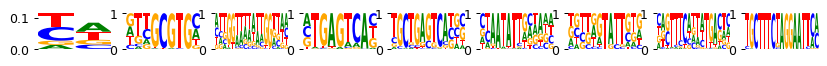

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels 0-69, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 10 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


 20%|████████████████████████████▊                                                                                                                   | 2/10 [00:26<01:47, 13.42s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.27s/it]


Current time: 2024-08-05 17:52:45.089841
	Loss: 400.529 , R2: 0.629
	Training time (model/function): (132.806s / 132.806s)
		per epoch (model/function): (14.756s/ 14.756s)
		per 1k samples: 5.036s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.864804495254649, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels 70-139, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:25<00:00, 13.26s/it]


Current time: 2024-08-05 17:57:15.061806
	Loss: 375.221 , R2: 0.629
	Training time (model/function): (398.092s / 265.286s)
		per epoch (model/function): (20.952s/ 13.962s)
		per 1k samples: 4.765s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.864804495254649, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.32s/it]


Current time: 2024-08-05 18:01:45.782366
	Loss: 144.967 , R2: 0.629
	Training time (model/function): (664.565s / 266.473s)
		per epoch (model/function): (34.977s/ 14.025s)
		per 1k samples: 4.787s
best loss 144.967
last five r2 values, by sequential filter optimization: ['0.629']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.864804495254649, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels 140-209, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:23<00:00, 13.19s/it]


Current time: 2024-08-05 18:06:18.149240
	Loss: 372.741 , R2: 0.629
	Training time (model/function): (928.487s / 263.922s)
		per epoch (model/function): (48.868s/ 13.891s)
		per 1k samples: 4.741s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.864804495254649, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:25<00:00, 13.25s/it]


Current time: 2024-08-05 18:10:47.029990
	Loss: 144.737 , R2: 0.629
	Training time (model/function): (1193.683s / 265.197s)
		per epoch (model/function): (62.825s/ 13.958s)
		per 1k samples: 4.764s
best loss 144.718
last five r2 values, by sequential filter optimization: ['0.629', '0.629']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.864804495254649, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels 210-279, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:23<00:00, 13.15s/it]


Current time: 2024-08-05 18:15:18.695149
	Loss: 372.720 , R2: 0.629
	Training time (model/function): (1456.759s / 263.075s)
		per epoch (model/function): (76.672s/ 13.846s)
		per 1k samples: 4.726s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.864804495254649, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 8/20 [01:46<02:39, 13.29s/it]

In [327]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 10
n_epochs_kernel = 20
log_each=75
n_unfreeze_kernels=70

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float).squeeze(1))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [337]:
model_by_logdynamic

{True: Mubind(
   (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
   (binding_modes): BindingLayer(
     (conv_mono): ModuleList(
       (0): None
       (1): Conv1d(4, 1, kernel_size=(2,), stride=(1,), bias=False)
       (2): Conv1d(4, 1, kernel_size=(9,), stride=(1,), bias=False)
       (3): Conv1d(4, 1, kernel_size=(18,), stride=(1,), bias=False)
       (4): Conv1d(4, 1, kernel_size=(9,), stride=(1,), bias=False)
       (5): Conv1d(4, 1, kernel_size=(13,), stride=(1,), bias=False)
       (6): Conv1d(4, 1, kernel_size=(14,), stride=(1,), bias=False)
       (7): Conv1d(4, 1, kernel_size=(13,), stride=(1,), bias=False)
       (8-9): 2 x Conv1d(4, 1, kernel_size=(17,), stride=(1,), bias=False)
       (10): Conv1d(4, 1, kernel_size=(13,), stride=(1,), bias=False)
       (11): Conv1d(4, 1, kernel_size=(12,), stride=(1,), bias=False)
       (12): Conv1d(4, 1, kernel_size=(15,), stride=(1,), bias=False)
       (13): Conv1d(4, 1, kernel_size=(8,), stride=(1,), bias=False)
      

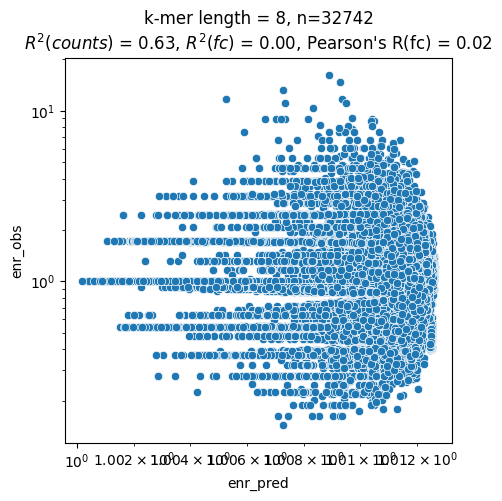

{'r2_counts': 0.6289044618606567,
 'r2_foldchange': -0.001452803611755371,
 'r2_enr': -0.047147393226623535,
 'r2_fc': 0.00046161110510426146,
 'pearson_foldchange': 0.021485136841646168}

In [345]:
rcParams['figure.figsize'] = 5, 5
mb.pl.kmer_enrichment(model_by_logdynamic[True], train, k=8, style='scatter')

In [346]:
model.binding_modes.conv_mono[1](torch.ones((1, 4, 256)).cuda())

tensor([[[0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365, 0.2365,
          0.2365, 0.2365, 0.2365, 0.23

In [347]:
lib_sizes = train.dataset.rounds.sum(axis=0).flatten()

In [348]:
for use_logdynamic in [False, True]:
    p = 'dentategyrus_use_logdynamic_%i_obs%i.pth' % (use_logdynamic, ad.shape[0])
    print(p)
    torch.save(model_by_logdynamic[use_logdynamic], p)

dentategyrus_use_logdynamic_0_obs2930.pth
dentategyrus_use_logdynamic_1_obs2930.pth


In [349]:
ad.shape

(2930, 13187)

In [350]:
ad.write('dentategyrus_sample_train_obs%i.h5ad' % ad.shape[0])

In [352]:
import pickle
pickle.dump(train, open('dentategyrus_train_dataloader_obs%i.pkl' % ad.shape[0], 'wb'))